## Title
Feature Engineering

### By:
Juan Gómez

### Date:
2024-05-16

### Description:

Clean and prepare message data from the Yelp dataset for the classification model. Remove duplicates, fix missing values, and keep useful columns only.

## Import  libraries

In [1]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow as pa
from sentence_transformers import SentenceTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## Load data

In [2]:
from pathlib import Path

pd.set_option("display.max_columns", None)

BASE_DIR = Path.cwd().resolve().parents[1]

In [3]:
df = pd.read_parquet(BASE_DIR / "data/03_primary/data_message_classifier_primary.parquet")

In [4]:
df.sample(5)

,review_id,stars,useful,funny,cool,text,date,review_count,useful_user,funny_user,cool_user,elite,fans,average_stars,address,city,state,stars_user,is_open,categories
251532,Xmw23uKU6BX74x1qNKkOyQ,5,3,0,3,I first visited Heidenreich in search of a Chr...,2020-11-21 22:22:06,19,17,0,19,,1,4.80,502 National Ave,Indianapolis,IN,4.5,True,"Shopping, Nurseries & Gardening, Home & Garden"
371519,8TlaT5-m-6YE9pSM-3rJ2g,5,3,0,3,First time customer! Wanted some boba tea and ...,2020-04-27 00:01:00,1015,3844,1071,3269,"2018,2019,20,20,2021",73,4.02,2732 E Fowler Ave,Tampa,FL,4.5,True,"Food, Bubble Tea, Restaurants, Desserts, Ice C..."
839397,gxZA_78vAKXIWTid9zYZPQ,5,1,1,0,"Wow, these guys are great! They arrived on tim...",2018-11-29 17:56:44,2,3,1,0,,0,5.00,1809 Primrose Ave,Nashville,TN,3.5,True,"Local Services, Packing Supplies, Shopping, Se..."
169239,RcAnFE3zl3tbbYG1ATXjPg,4,1,0,0,Dettera was the perfect place to go for a nice...,2021-04-05 19:09:19,11,10,2,4,,0,4.08,129 E Butler Ave,Ambler,PA,4.0,True,"Restaurants, American (New)"
699360,YV4knf0L9Y5KIBgu6SUsZQ,5,4,0,0,"Ok, let me be clear. Everyone has different ty...",2019-04-17 15:29:16,9,15,1,3,,1,3.70,672 Hickory Ave,Harahan,LA,5.0,True,"Skin Care, Hair Removal, Laser Hair Removal, B..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000092 entries, 0 to 1000091
Data columns (total 20 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   review_id      1000092 non-null  object        
 1   stars          1000092 non-null  int64         
 2   useful         1000092 non-null  int32         
 3   funny          1000092 non-null  int32         
 4   cool           1000092 non-null  int32         
 5   text           1000092 non-null  object        
 6   date           1000092 non-null  datetime64[ns]
 7   review_count   1000092 non-null  int32         
 8   useful_user    1000092 non-null  int32         
 9   funny_user     1000092 non-null  int32         
 10  cool_user      1000092 non-null  int32         
 11  elite          1000092 non-null  category      
 12  fans           1000092 non-null  int32         
 13  average_stars  1000092 non-null  float64       
 14  address        1000092 non-null  o

In [6]:
df.shape

(1000092, 20)

# Data Preparation

### Type Columns

In [7]:
cols_categoric = df.select_dtypes(include=["category"]).columns.tolist()

In [8]:
cols_num = df.select_dtypes(include=["int32", "float64"]).columns.tolist()

In [9]:
cols_boolean = df.select_dtypes(include=["bool"]).columns.tolist()

In [10]:
cols_string = df.select_dtypes(include=["object"]).columns.tolist()

In [11]:
col_date = df.select_dtypes(include=["datetime64[ns]"]).columns.tolist()

### Handle outliers

In [12]:
for col in cols_num:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col}: {len(outliers)} outliers")

useful: 141006 outliers
funny: 239039 outliers
cool: 95121 outliers
review_count: 109876 outliers
useful_user: 148464 outliers
funny_user: 158500 outliers
cool_user: 155529 outliers
fans: 148423 outliers
average_stars: 74375 outliers
stars_user: 28171 outliers


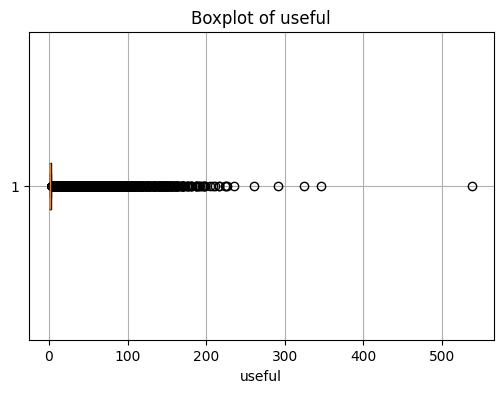

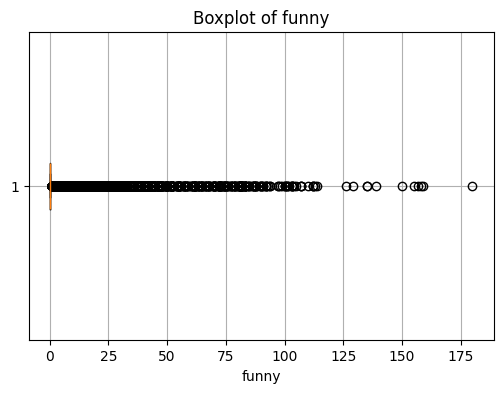

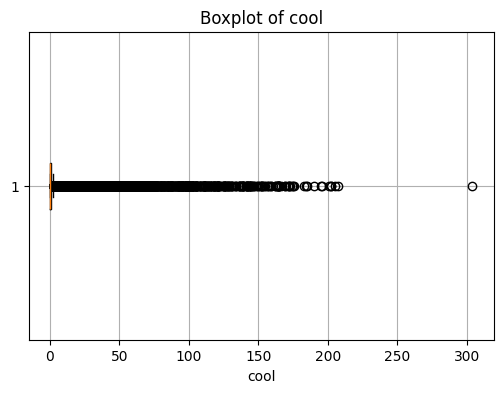

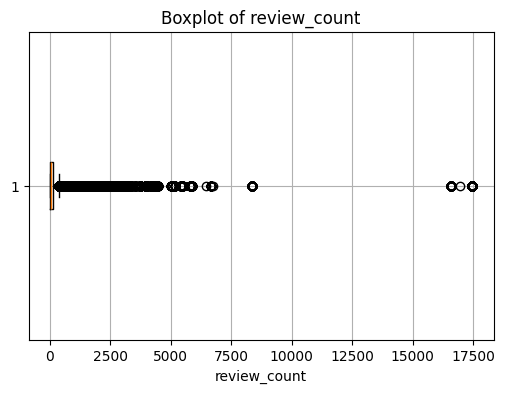

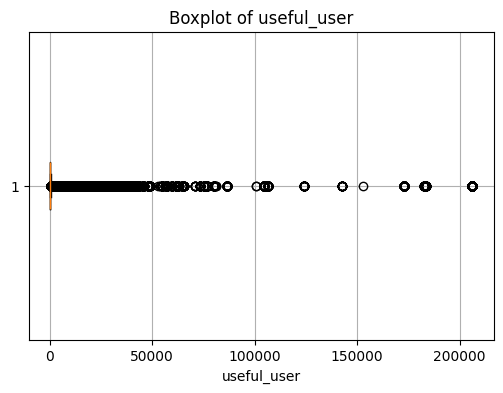

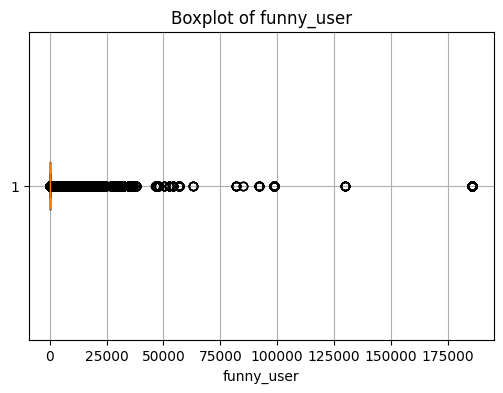

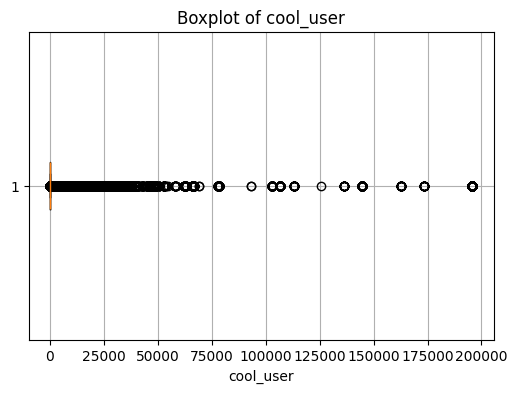

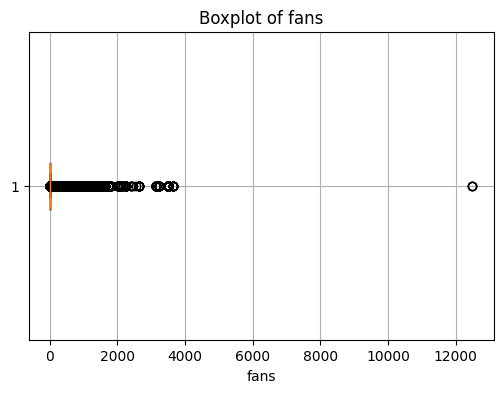

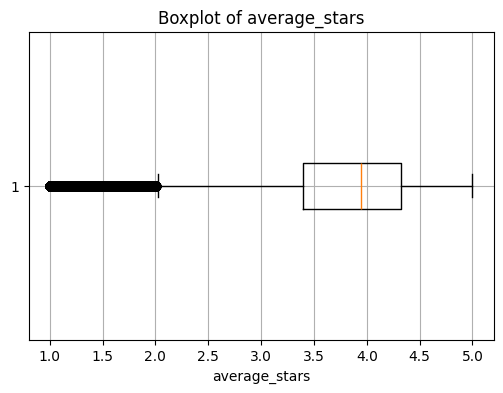

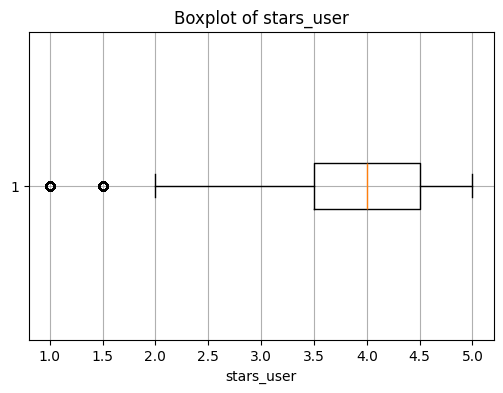

In [13]:
for col in cols_num:
    plt.figure(figsize=(6, 4))
    plt.boxplot(df[col].dropna(), vert=False)
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.grid(True)
    plt.show()

# Feature Engineering

In [14]:
df2 = df.copy()

## Aggregate

### Categorical Variables

In [15]:
cols_categoric.append("stars")
df2[cols_categoric] = df2[cols_categoric].astype("category")

In [16]:
cols_categoric

['elite', 'city', 'state', 'stars']

#### Elite

In [17]:
def fix_elite_format(val):
    if pd.isna(val) or val == "None":
        return None

    years = {"20" + y if len(y) == 2 and y.isdigit() else y.strip() for y in val.split(",")}
    return ",".join(sorted(years))

In [18]:
df2["elite"] = df2["elite"].apply(fix_elite_format)

In [19]:
df2["elite_count"] = (
    df2["elite"].fillna("").apply(lambda x: 0 if x in ["None", ""] else len(x.split(",")))
).astype("int32")

#### City

In [20]:
city_freq = df2["city"].value_counts(normalize=True)
df2["city_freq"] = df2["city"].map(city_freq).astype("float64")

#### State

In [21]:
state_freq = df2["state"].value_counts(normalize=True)
df2["state_freq"] = df2["state"].map(state_freq).astype("float64")

#### Pipeline

- EliteAggregateTransformer

In [22]:
class EliteAggregateTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        def fix_elite(val):
            if pd.isna(val) or val == "None":
                return ""
            years = {"20" + y if len(y) == 2 and y.isdigit() else y.strip() for y in val.split(",")}
            return ",".join(sorted(years))

        X["elite"] = X["elite"].apply(fix_elite)
        X["elite_count"] = (
            X["elite"].apply(lambda x: 0 if x == "" else len(x.split(","))).astype("int32")
        )
        return X

    def set_output(self, *, transform=None):
        return self

- FrequencyEncodeAggregateTransformer

In [23]:
class FrequencyEncodeAggregateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.freq_maps = {}

    def fit(self, X, y=None):
        for col in self.columns:
            self.freq_maps[col] = X[col].value_counts(normalize=True)
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            X[f"{col}_freq"] = X[col].map(self.freq_maps[col]).astype("float64")
        return X

    def set_output(self, *, transform=None):
        return self

- Pipeline

In [24]:
categorical_aggregate_pipe = Pipeline(
    steps=[
        ("elite_agg", EliteAggregateTransformer()),
        (
            "freq_encode_agg",
            FrequencyEncodeAggregateTransformer(columns=["city", "state"]),
        ),
    ]
)

### Numerical Variables

In [25]:
cols_num

['useful',
 'funny',
 'cool',
 'review_count',
 'useful_user',
 'funny_user',
 'cool_user',
 'fans',
 'average_stars',
 'stars_user']

#### Useful

In [26]:
df2["is_useful"] = (df2["useful"] > 0).astype(bool)

#### Funny

In [27]:
df2["is_funny"] = (df2["funny"] > 0).astype(bool)

#### Cool

In [28]:
df2["is_cool"] = (df2["cool"] > 0).astype(bool)

#### Review Count

In [29]:
df2["reviewer_level"] = pd.qcut(df2["review_count"], q=4, labels=[0, 1, 2, 3]).astype("int8")

#### Useful User

In [30]:
df2["useful_user_level"] = pd.qcut(df2["useful_user"], q=4, labels=[0, 1, 2, 3]).astype("int8")

#### Funny User

In [31]:
df2["funny_user_level"] = pd.qcut(df2["funny_user"], q=4, labels=[0, 1, 2, 3]).astype("int8")

#### Cool User

In [32]:
df2["cool_user_level"] = pd.qcut(df2["cool_user"], q=4, labels=[0, 1, 2, 3]).astype("int8")

#### Fans

In [33]:
p90 = df2["fans"][df2["fans"] > 0].quantile(0.90)


def map_fans_level(x):
    if x == 0:
        return 0
    elif x <= p90:
        return 1
    else:
        return 2


df2["fans_level"] = df2["fans"].apply(map_fans_level).astype("int8")

#### Pipeline

- BinaryFlagAggregateTransformer

In [34]:
class BinaryFlagAggregateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            X[f"is_{col}"] = (X[col] > 0).astype(bool)
        return X

    def set_output(self, *, transform=None):
        return self

- QCutLevelAggregateTransformer

In [35]:
class QCutLevelAggregateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns, labels=[0, 1, 2, 3]):
        self.columns = columns
        self.labels = labels

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            X[f"{col}_level"] = pd.qcut(X[col], q=4, labels=self.labels, duplicates="drop").astype(
                "int32"
            )
        return X

    def set_output(self, *, transform=None):
        return self

- FansLevelAggregateTransformer

In [36]:
class FansLevelAggregateTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.p90 = X["fans"][X["fans"] > 0].quantile(0.90)
        return self

    def transform(self, X):
        X = X.copy()

        def map_fans_level(x):
            if x == 0:
                return 0
            elif x <= self.p90:
                return 1
            else:
                return 2

        X["fans_level"] = X["fans"].apply(map_fans_level).astype("int32")
        return X

    def set_output(self, *, transform=None):
        return self

- Pipeline

In [37]:
numerical_aggregate_pipe = Pipeline(
    steps=[
        (
            "binary_flags_agg",
            BinaryFlagAggregateTransformer(columns=["useful", "funny", "cool"]),
        ),
        (
            "qcut_levels_agg",
            QCutLevelAggregateTransformer(
                columns=["review_count", "useful_user", "funny_user", "cool_user"]
            ),
        ),
        ("fans_level_agg", FansLevelAggregateTransformer()),
    ]
)

### String Variables

In [38]:
cols_string

['review_id', 'text', 'address', 'categories']

#### Text

In [39]:
df2["text_length"] = df2["text"].str.len().astype("int64")
df2["word_count"] = df2["text"].str.split().str.len().astype("int32")
df2["has_exclamation"] = df2["text"].str.contains(r"[!¡]{1,}", regex=True).astype(bool)

#### Categories

In [40]:
category_patterns = {
    "restaurant": r"\brestaurant|pizza|food|diner\b",
    "bar": r"\bbar|pub|nightlife|cocktail\b",
    "health": r"\bhealth|spa|doctor|clinic|fitness|dentist\b",
}

In [41]:
def categorize_business(cats):
    if pd.isna(cats):
        return "other"
    cats = cats.lower()
    for label, pattern in category_patterns.items():
        if re.search(pattern, cats):
            return label
    return "other"

In [42]:
df2["main_category_group"] = df2["categories"].apply(categorize_business).astype("category")

In [43]:
df2["category_count"] = df2["categories"].fillna("").str.split(",").str.len().astype("int32")

#### Pipeline

- TextLengthAggregateTransformer

In [44]:
class TextLengthAggregateTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["text_length"] = X["text"].str.len().fillna(0).astype("int64")
        return X

    def set_output(self, *, transform=None):
        return self

- WordCountAggregateTransformer

In [45]:
class WordCountAggregateTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["word_count"] = X["text"].fillna("").str.split().str.len().astype("int32")
        return X

    def set_output(self, *, transform=None):
        return self

- ExclamationFlagAggregateTransformer

In [46]:
class ExclamationFlagAggregateTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["has_exclamation"] = (
            X["text"].str.contains(r"[!¡]{1,}", regex=True, na=False).astype(bool)
        )
        return X

    def set_output(self, *, transform=None):
        return self

- CategoryGroupAggregateTransformer

In [47]:
class CategoryGroupAggregateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.patterns = {
            "restaurant": r"\brestaurant|pizza|food|diner\b",
            "bar": r"\bbar|pub|nightlife|cocktail\b",
            "health": r"\bhealth|spa|doctor|clinic|fitness|dentist\b",
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        def categorize(cats):
            if pd.isna(cats):
                return "other"
            cats = cats.lower()
            for label, pattern in self.patterns.items():
                if re.search(pattern, cats):
                    return label
            return "other"

        X["main_category_group"] = X["categories"].apply(categorize).astype("category")
        return X

    def set_output(self, *, transform=None):
        return self

- CategoryCountAggregateTransformer

In [48]:
class CategoryCountAggregateTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["category_count"] = X["categories"].fillna("").str.split(",").str.len().astype("int32")
        return X

    def set_output(self, *, transform=None):
        return self

- Pipeline

In [49]:
string_aggregate_pipe = Pipeline(
    steps=[
        ("text_length", TextLengthAggregateTransformer()),
        ("word_count", WordCountAggregateTransformer()),
        ("has_exclamation", ExclamationFlagAggregateTransformer()),
        ("category_group", CategoryGroupAggregateTransformer()),
        ("category_count", CategoryCountAggregateTransformer()),
    ]
)

### Data Variables

In [50]:
col_date

['date']

#### Date

In [51]:
df2["review_year"] = df2["date"].dt.year.astype("category")
df2["review_month"] = df2["date"].dt.month.astype("category")
df2["review_dayofweek"] = df2["date"].dt.dayofweek
df2["is_weekend"] = (df2["review_dayofweek"] >= 5).astype("bool")
df2["review_dayofweek"] = df2["review_dayofweek"].astype("category")
df2["review_quarter"] = df2["date"].dt.quarter.astype("category")

#### Pipeline

- DateAggregateTransformer

In [52]:
class DateAggregateTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Asegurarse de que 'date' sea datetime
        X["date"] = pd.to_datetime(X["date"], errors="coerce")

        # Derivados temporales
        X["review_year"] = X["date"].dt.year.astype("category")
        X["review_month"] = X["date"].dt.month.astype("category")
        X["review_dayofweek"] = X["date"].dt.dayofweek
        X["is_weekend"] = (X["review_dayofweek"] >= 5).astype("bool")
        X["review_dayofweek"] = X["review_dayofweek"].astype("category")
        X["review_quarter"] = X["date"].dt.quarter.astype("category")

        return X

    def set_output(self, *, transform=None):
        return self

In [53]:
date_aggregate_pipe = Pipeline(steps=[("date_agg", DateAggregateTransformer())])

### Aggregate Pipeline

In [54]:
aggregate_preprocessor = ColumnTransformer(
    transformers=[
        ("cat_agg", categorical_aggregate_pipe, ["elite", "city", "state"]),
        (
            "num_agg",
            numerical_aggregate_pipe,
            [
                "useful",
                "funny",
                "cool",
                "review_count",
                "useful_user",
                "funny_user",
                "cool_user",
                "fans",
            ],
        ),
        ("str_agg", string_aggregate_pipe, ["text", "categories"]),
        ("date_agg", date_aggregate_pipe, ["date"]),
    ],
    remainder="passthrough",
)

## Compress

- DropColumnsTransformer

In [55]:
class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns, errors="ignore")

    def set_output(self, *, transform=None):
        return self

### Categorical Variables

In [56]:
df2.select_dtypes(include=["category"]).columns.tolist()

['stars',
 'elite',
 'city',
 'state',
 'main_category_group',
 'review_year',
 'review_month',
 'review_dayofweek',
 'review_quarter']

In [57]:
categorical_compress_pipe = Pipeline(
    steps=[
        (
            "cat_drop",
            DropColumnsTransformer(columns=["cat_agg__city", "cat_agg__state", "cat_agg__elite"]),
        )
    ]
)

### Numerical Variables

In [58]:
df2.select_dtypes(include=["int8", "int32", "int64", "float64"]).columns.tolist()

['useful',
 'funny',
 'cool',
 'review_count',
 'useful_user',
 'funny_user',
 'cool_user',
 'fans',
 'average_stars',
 'stars_user',
 'elite_count',
 'city_freq',
 'state_freq',
 'reviewer_level',
 'useful_user_level',
 'funny_user_level',
 'cool_user_level',
 'fans_level',
 'text_length',
 'word_count',
 'category_count']

In [59]:
numerical_compress_pipe = Pipeline(
    steps=[
        (
            "num_drop",
            DropColumnsTransformer(
                columns=[
                    "num_agg__useful_user",
                    "num_agg__funny_user",
                    "num_agg__cool_user",
                    "num_agg__fans",
                    "remainder__average_stars",
                    "remainder__stars_user",
                ]
            ),
        )
    ]
)

### String Variables

In [60]:
df2.select_dtypes(include=["object"]).columns.tolist()

['review_id', 'text', 'address', 'categories']

In [61]:
string_compress_pipe = Pipeline(
    steps=[
        (
            "str_drop",
            DropColumnsTransformer(
                columns=[
                    "str_agg__categories",
                    "remainder__review_id",
                    "remainder__address",
                ]
            ),
        )
    ]
)

### Data Variables

In [62]:
df2.select_dtypes(include=["datetime64[ns]"]).columns.tolist()

['date']

In [63]:
date_compress_pipe = Pipeline(
    steps=[("date_drop", DropColumnsTransformer(columns=["date_agg__date"]))]
)

### Compress Pipeline

In [64]:
compress_preprocessor = Pipeline(
    steps=[
        ("cat_compress", categorical_compress_pipe),
        ("num_compress", numerical_compress_pipe),
        ("str_compress", string_compress_pipe),
        ("date_compress", date_compress_pipe),
    ]
)

## Model-Independent Transformation

### Remove Duplicates

- DuplicateRemoverTransformer

In [65]:
class DuplicateRemoverTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop_duplicates()

    def set_output(self, *, transform=None):
        return self

- Pipeline

In [66]:
dedup_mit_pipe = Pipeline(steps=[("dedup", DuplicateRemoverTransformer())])

### Text Cleaner

- TextCleanerTransformer

In [67]:
class TextCleanerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="str_agg__text"):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[f"{self.column}_clean"] = (
            X[self.column]
            .fillna("")
            .str.lower()
            .str.replace(r"[^\w\s]", "", regex=True)
            .str.replace(r"\s+", " ", regex=True)
            .str.strip()
        ).astype("object")
        return X

    def set_output(self, *, transform=None):
        return self

- Pipeline

In [68]:
text_clean_mit_pipe = Pipeline(
    steps=[
        ("text_clean", TextCleanerTransformer(column="str_agg__text")),
        ("text_original_drop", DropColumnsTransformer(columns=["str_agg__text"])),
    ]
)

### Category Stats

- CategoryStatsTransformer

In [69]:
class CategoryStatsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, group_col="str_agg__main_category_group", value_col="str_agg__text_length"):
        self.group_col = group_col
        self.value_col = value_col

    def fit(self, X, y=None):
        X_valid = X[[self.group_col, self.value_col]].dropna()

        self.group_mean = pd.to_numeric(
            X_valid.groupby(self.group_col, observed=True)[self.value_col].mean(),
            errors="coerce",
        )
        self.group_std = pd.to_numeric(
            X_valid.groupby(self.group_col, observed=True)[self.value_col].std().fillna(0),
            errors="coerce",
        )
        return self

    def transform(self, X):
        X = X.copy()

        X[self.value_col] = pd.to_numeric(X[self.value_col], errors="coerce")
        avg = pd.to_numeric(X[self.group_col].map(self.group_mean), errors="coerce")
        std = pd.to_numeric(X[self.group_col].map(self.group_std), errors="coerce")

        X["str_agg__avg_text_length_per_category"] = avg.astype("float32")
        X["str_agg__std_text_length_per_category"] = std.astype("float32")
        X["str_agg__relative_length"] = (X[self.value_col] - avg).astype("float32")

        return X

    def set_output(self, *, transform=None):
        return self

- Pipeline

In [70]:
cat_stats_mit_pipe = Pipeline(
    steps=[
        (
            "cat_stats",
            CategoryStatsTransformer(
                group_col="str_agg__main_category_group",
                value_col="str_agg__text_length",
            ),
        )
    ]
)

### Text Embedding

- TextEmbeddingTransformer

In [ ]:
class TextEmbeddingTransformer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        column="str_agg__text_clean",
        model_name="sentence-transformers/paraphrase-albert-small-v2",
        n_components=None,
    ):
        self.column = column
        self.model_name = model_name
        self.n_components = n_components

    def fit(self, X, y=None):
        self.model = SentenceTransformer(self.model_name)
        return self

    def transform(self, X):
        X = X.copy()
        texts = X[self.column].fillna("").tolist()
        embeddings = self.model.encode(texts, show_progress_bar=False)
        if self.n_components is not None:
            embeddings = embeddings[:, : self.n_components]
        emb_cols = [f"{self.column}_emb_{i}" for i in range(embeddings.shape[1])]
        emb_df = pd.DataFrame(embeddings, columns=emb_cols, index=X.index)
        return pd.concat([X, emb_df], axis=1)

    def set_output(self, *, transform=None):
        return self

- Pipeline

In [ ]:
embed_mit_pipe = Pipeline(
    steps=[
        (
            "text_embed",
            TextEmbeddingTransformer(
                column="str_agg__text_clean",
                model_name="sentence-transformers/paraphrase-albert-small-v2",
                n_components=50,
            ),
        ),
        ("text_original_drop", DropColumnsTransformer(columns=["str_agg__text_clean"])),
    ]
)

### MIT Pipeline

In [73]:
mit_preprocessor = Pipeline(
    steps=[
        ("dedup_mit_pipe", dedup_mit_pipe),
        ("text_clean_mit_pipe", text_clean_mit_pipe),
        ("cat_stats_mit_pipe", cat_stats_mit_pipe),
        ("embed_mit_pipe", embed_mit_pipe),
    ]
)

## Feature Engineering Pipeline

In [74]:
aggregate_preprocessor.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat_agg',
                                 Pipeline(steps=[('elite_agg',
                                                  EliteAggregateTransformer()),
                                                 ('freq_encode_agg',
                                                  FrequencyEncodeAggregateTransformer(columns=['city',
                                                                                               'state']))]),
                                 ['elite', 'city', 'state']),
                                ('num_agg',
                                 Pipeline(steps=[('binary_flags_agg',
                                                  BinaryFlagAggregateTransformer(columns=['useful',
                                                                                          'funny',
                                                                                          'cool'])),
                                                 (...
                                                  TextLengthAggregateTransformer()),
                                                 ('word_count',
                                                  WordCountAggregateTransformer()),
                                                 ('has_exclamation',
                                                  ExclamationFlagAggregateTransformer()),
                                                 ('category_group',
                                                  CategoryGroupAggregateTransformer()),
                                                 ('category_count',
                                                  CategoryCountAggregateTransformer())]),
                                 ['text', 'categories']),
                                ('date_agg',
                                 Pipeline(steps=[('date_agg',
                                                  DateAggregateTransformer())]),
                                 ['date'])])

In [75]:
compress_preprocessor.set_output(transform="pandas")

Pipeline(steps=[('cat_compress',
                 Pipeline(steps=[('cat_drop',
                                  DropColumnsTransformer(columns=['cat_agg__city',
                                                                  'cat_agg__state',
                                                                  'cat_agg__elite']))])),
                ('num_compress',
                 Pipeline(steps=[('num_drop',
                                  DropColumnsTransformer(columns=['num_agg__useful_user',
                                                                  'num_agg__funny_user',
                                                                  'num_agg__cool_user',
                                                                  'num_agg__fans',
                                                                  'remainder__average_stars',
                                                                  'remainder__stars_user']))])),
                ('str_compress',
                 Pipeline(steps=[('str_drop',
                                  DropColumnsTransformer(columns=['str_agg__categories',
                                                                  'remainder__review_id',
                                                                  'remainder__address']))])),
                ('date_compress',
                 Pipeline(steps=[('date_drop',
                                  DropColumnsTransformer(columns=['date_agg__date']))]))])

In [76]:
mit_preprocessor.set_output(transform="pandas")

Pipeline(steps=[('dedup_mit_pipe',
                 Pipeline(steps=[('dedup', DuplicateRemoverTransformer())])),
                ('text_clean_mit_pipe',
                 Pipeline(steps=[('text_clean', TextCleanerTransformer()),
                                 ('text_original_drop',
                                  DropColumnsTransformer(columns=['str_agg__text']))])),
                ('cat_stats_mit_pipe',
                 Pipeline(steps=[('cat_stats', CategoryStatsTransformer())])),
                ('embed_mit_pipe',
                 Pipeline(steps=[('text_embed', TextEmbeddingTransformer()),
                                 ('text_original_drop',
                                  DropColumnsTransformer(columns=['str_agg__text_clean']))]))])

In [ ]:
from sklearn import set_config

set_config(display="diagram")

In [88]:
feature_pipeline = Pipeline(
    steps=[
        ("aggregate", aggregate_preprocessor),
        ("compress", compress_preprocessor),
        ("mit", mit_preprocessor),
    ]
)

## Sampling 1% most recent records for example

In [80]:
# df_sorted = df.sort_values(by="date", ascending=False)

In [81]:
# n = int(len(df_sorted) * 0.01)
# df_top_1_percent = df_sorted.head(n)

## Save reviews data feature

In [ ]:
# df_feature = feature_pipeline.fit_transform(df)

In [ ]:
# df_feature.info()

In [ ]:
# schema = pa.Schema.from_pandas(df_feature, preserve_index=False)

In [ ]:
# schema

In [ ]:
df_feature.to_parquet(
    BASE_DIR / "data/04_feature/data_message_classifier_feature.parquet",
    index=False,
    schema=schema,
)